# HIV/AIDS Epidemic Modeling in Cuba (1986-2000)

## Based on De Arazoza & Lounes (2002) Data

This notebook demonstrates the application of compartmental epidemiological models to HIV/AIDS data from Cuba. The model code is maintained in a separate module (`hiv_models.py`) for reusability across projects. 

**Reference:** H. De Arazoza and R. Lounes, "A non-linear model for a sexually transmitted disease with contact tracing," *IMA Journal of Mathematical Medicine and Biology*, 19(2002), pp. 221-234. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import differential_evolution
import seaborn as sns
from pathlib import Path

import sys, os
sys.path.append(os.path.abspath(os.path.join('..', 'src')))
from hiv_models import (
    hiv_model,
    hiv_model_with_control,
    simulate_model,
    calculate_r0,
    calculate_derived_quantities,
    objective_function,
    calculate_new_cases,
    calculate_r_squared,
    project_scenarios,
    calculate_impact_metrics
)
# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

rseed = 42

## Data Loading and Preparation

In [2]:
# Historical data from the De Arazoza & Lounes article
data = {
    'Year': [1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000],
    'HIV_cases': [99, 75, 93, 121, 140, 183, 175, 102, 122, 124, 234, 363, 362, 493, 545],
    'AIDS_cases': [5, 11, 14, 13, 28, 37, 71, 82, 102, 116, 99, 129, 150, 176, 251],
    'Deaths': [2, 4, 6, 5, 23, 17, 32, 59, 62, 80, 92, 99, 98, 122, 142]
}

df = pd.DataFrame(data)
df['Time'] = df['Year'] - 1986  # Time in years since 1986

# Calculate cumulative numbers
df['Cumulative_HIV'] = df['HIV_cases'].cumsum()
df['Cumulative_AIDS'] = df['AIDS_cases'].cumsum()
df['Cumulative_Deaths'] = df['Deaths'].cumsum()

print("Historical Data Summary:")
print(df[['Year', 'HIV_cases', 'AIDS_cases', 'Deaths']].to_string(index=False))
print(f"\nTotal HIV cases by 2000: {df['Cumulative_HIV'].iloc[-1]}")
print(f"Total AIDS cases by 2000: {df['Cumulative_AIDS'].iloc[-1]}")
print(f"Total Deaths by 2000: {df['Cumulative_Deaths'].iloc[-1]}")

Historical Data Summary:
 Year  HIV_cases  AIDS_cases  Deaths
 1986         99           5       2
 1987         75          11       4
 1988         93          14       6
 1989        121          13       5
 1990        140          28      23
 1991        183          37      17
 1992        175          71      32
 1993        102          82      59
 1994        122         102      62
 1995        124         116      80
 1996        234          99      92
 1997        363         129      99
 1998        362         150      98
 1999        493         176     122
 2000        545         251     142

Total HIV cases by 2000: 3231
Total AIDS cases by 2000: 1284
Total Deaths by 2000: 843


## Model Structure

For this analysis I use a modified SEIR-type compartmental model with the following states:

- **S**: Susceptible population
- **H**: HIV-positive individuals (untreated)
- **T**: HIV-positive individuals under treatment (contact traced)
- **A**: AIDS patients
- **D**: Cumulative deaths from AIDS

### Differential Equations:

$$\frac{dS}{dt} = -\beta S \frac{H}{N} + \mu N - \mu S$$

$$\frac{dH}{dt} = \beta S \frac{H}{N} - \alpha H - \tau H - \mu H$$

$$\frac{dT}{dt} = \tau H - \alpha_T T - \mu T$$

$$\frac{dA}{dt} = \alpha H + \alpha_T T - \delta A - \mu A$$

$$\frac{dD}{dt} = \delta A$$

### Parameters:

- $\beta$: Transmission rate (per year)
- $\alpha$: HIV → AIDS progression rate, untreated (per year)
- $\alpha_T$: HIV → AIDS progression rate, treated (per year)
- $\tau$: Contact tracing/treatment initiation rate (per year)
- $\delta$: AIDS mortality rate (per year)
- $\mu$: Natural birth/death rate (per year)

## Parameter Estimation via Optimization

To estimate model parameters, I fit the observed data using differential evolution optimization. 

In [3]:
# population and time
N = 11e6
t_data = df['Time'].values
t_sim = np.linspace(0, 14, 1000) 

# initial conditions
H0 = df['HIV_cases'].iloc[0]    # initial HIV cases
A0 = df['AIDS_cases'].iloc[0]   # initial AIDS cases
T0 = 0                          # no initial treatment
D0 = df['Deaths'].iloc[0]       # initial deaths
S0 = N - H0 - A0 - T0           # initial susceptible population
y0 = [S0, H0, T0, A0, D0]

# parameter bounds for optimization [beta, alpha, alpha_T, tau, delta, mu]
bounds = [
    (0.01, 2.0),    # beta: transmission rate
    (0.05, 0.5),    # alpha: HIV to AIDS progression (untreated)
    (0.01, 0.3),    # alpha_T: HIV to AIDS progression (treated)
    (0.0, 0.5),     # tau: contact tracing rate
    (0.05, 1.0),    # delta: AIDS death rate 
    (0.0, 0.02)     # mu: natural birth/death rate
]

print('Starting parameter optimization (this may take a few minutes)...')

# use differential evolution for global optimization
result = differential_evolution(
    objective_function,
    bounds, 
    args=(t_data, y0, N, df),
    strategy='best1bin',
    maxiter=300,
    popsize=15,
    tol=1e-7,
    seed=rseed,
    workers=1
)

# extract optimal parameters
beta_opt, alpha_opt, alpha_T_opt, tau_opt, delta_opt, mu_opt = result.x

# store in a dict for easy access
params_opt = {
    "beta": beta_opt,
    "alpha": alpha_opt,
    "alpha_T": alpha_T_opt,
    "tau": tau_opt,
    "delta": delta_opt,
    "mu": mu_opt
}

print("OPTIMAL PARAMETERS:")
print(f"β (transmission rate):              {beta_opt:.4f} per year")
print(f"α (HIV→AIDS, untreated):            {alpha_opt:.4f} per year")
print(f"α_T (HIV→AIDS, treated):            {alpha_T_opt:.4f} per year")
print(f"τ (contact tracing rate):           {tau_opt:.4f} per year")
print(f"δ (AIDS mortality rate):            {delta_opt:.4f} per year")
print(f"μ (natural birth/death rate):       {mu_opt:.4f} per year")
print(f"Objective function value: {result.fun:.6f}")

Starting parameter optimization (this may take a few minutes)...
OPTIMAL PARAMETERS:
β (transmission rate):              0.9319 per year
α (HIV→AIDS, untreated):            0.2353 per year
α_T (HIV→AIDS, treated):            0.0843 per year
τ (contact tracing rate):           0.5000 per year
δ (AIDS mortality rate):            0.1314 per year
μ (natural birth/death rate):       0.0200 per year
Objective function value: 1.352057


## Epidemiological Interpretation

Calculate derived epidemiological quantities from the fitted paramters.

In [4]:
derived = calculate_derived_quantities(params_opt)

print("Epidemiological Interpretation") 
print("\n1. Transmission Dynamics")
print(f"    Basic Reproduction number (R0): {derived['R0']:.3f}")
if derived["R0"] > 1: 
    print(f"    R0 > 1 indicates potential for epidemic growth") 
else:
    print(f"    R0 < 1 indicates epidemic will decline over time")

print(f"\n2. Disease Progression")
print(f"    Mean time HIV -> AIDS (untreated): {derived["mean_incubation_untreated"]:.2f} years") 
print(f"    Mean time HIV -> AIDS (treated): {derived['mean_incubation_treated']:.2f} years") 
print(f"    Treatment extends incubation by: {derived['treatment_benefit']:.2f}x")
print(f"    Mean survival with AIDS: {derived['mean_survival_aids']:.2f} years") 

print(f"\n3. Contact Tracing Effectiveness")
print(f"    Probability of being traced: {derived['tracing_probability']*100:.2f} %") 
if tau_opt > 0:
    print(f"    Average time to trace: {1/tau_opt:.2f} years")
else:
    print(f"    No active contact tracing detected")

Epidemiological Interpretation

1. Transmission Dynamics
    Basic Reproduction number (R0): 1.234
    R0 > 1 indicates potential for epidemic growth

2. Disease Progression
    Mean time HIV -> AIDS (untreated): 4.25 years
    Mean time HIV -> AIDS (treated): 11.86 years
    Treatment extends incubation by: 2.79x
    Mean survival with AIDS: 7.61 years

3. Contact Tracing Effectiveness
    Probability of being traced: 66.20 %
    Average time to trace: 2.00 years


## Model Validation 
Comparing model predictions to the observed data to assess goodness of fit. 

In [5]:
# simulate with optimal parameters
solution_fit = simulate_model(result.x, t_data, y0, N)
solution_sim = simulate_model(result.x, t_sim, y0, N)

# extract compartments
S_fit, H_hit, T_fit, A_fit, D_fit = solution_fit.T
S_sim, H_sim, T_sim, A_sim, D_sim = solution_sim.T 

# calculate new cases using imported function
new_cases_fit = calculate_new_cases(solution_fit)
new_HIV_fit = new_cases_fit['HIV']
new_AIDS_fit = new_cases_fit['AIDS']
new_Deaths_fit = new_cases_fit['Deaths'] 

# calculate R^2 values
r2_hiv = calculate_r_squared(df['HIV_cases'].values, new_HIV_fit)
r2_aids = calculate_r_squared(df['AIDS_cases'].values, new_AIDS_fit)
r2_deaths = calculate_r_squared(df['Deaths'].values, new_Deaths_fit)

print("\nModel Fit Quality (R² values):")
print(f"  HIV cases:   R² = {r2_hiv:.4f}")
print(f"  AIDS cases:  R² = {r2_aids:.4f}")
print(f"  Deaths:      R² = {r2_deaths:.4f}")
print("\n(R² = 1.0 is perfect fit; R² > 0.8 generally indicates good fit)")


Model Fit Quality (R² values):
  HIV cases:   R² = 0.8696
  AIDS cases:  R² = 0.9484
  Deaths:      R² = 0.9286

(R² = 1.0 is perfect fit; R² > 0.8 generally indicates good fit)


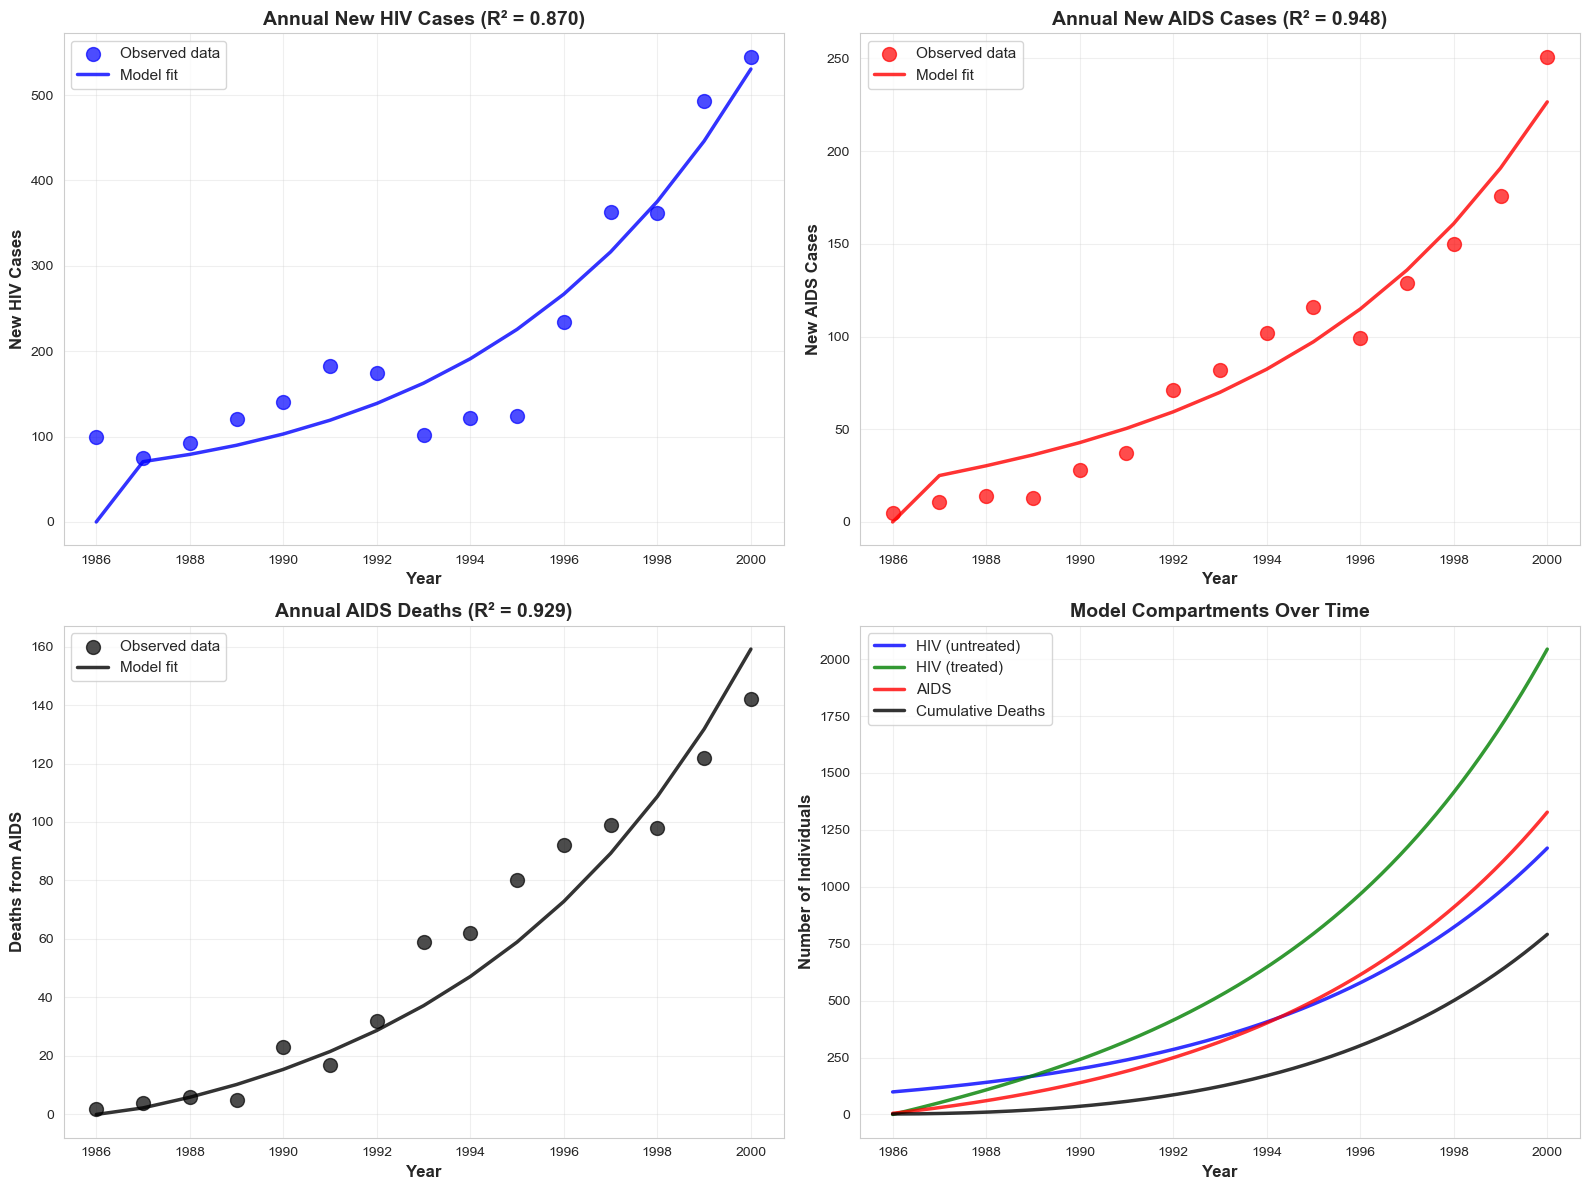

In [6]:
# Visualization: Model fit vs data
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: New HIV cases
axes[0, 0].scatter(df['Year'], df['HIV_cases'], color='blue', s=100, 
                   label='Observed data', alpha=0.7, zorder=3)
axes[0, 0].plot(df['Year'], new_HIV_fit, 'b-', linewidth=2.5, 
                label='Model fit', alpha=0.8)
axes[0, 0].set_xlabel('Year', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('New HIV Cases', fontsize=12, fontweight='bold')
axes[0, 0].set_title(f'Annual New HIV Cases (R² = {r2_hiv:.3f})', 
                     fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=11)
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: New AIDS cases
axes[0, 1].scatter(df['Year'], df['AIDS_cases'], color='red', s=100, 
                   label='Observed data', alpha=0.7, zorder=3)
axes[0, 1].plot(df['Year'], new_AIDS_fit, 'r-', linewidth=2.5, 
                label='Model fit', alpha=0.8)
axes[0, 1].set_xlabel('Year', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('New AIDS Cases', fontsize=12, fontweight='bold')
axes[0, 1].set_title(f'Annual New AIDS Cases (R² = {r2_aids:.3f})', 
                     fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=11)
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Deaths
axes[1, 0].scatter(df['Year'], df['Deaths'], color='black', s=100, 
                   label='Observed data', alpha=0.7, zorder=3)
axes[1, 0].plot(df['Year'], new_Deaths_fit, 'k-', linewidth=2.5, 
                label='Model fit', alpha=0.8)
axes[1, 0].set_xlabel('Year', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Deaths from AIDS', fontsize=12, fontweight='bold')
axes[1, 0].set_title(f'Annual AIDS Deaths (R² = {r2_deaths:.3f})', 
                     fontsize=14, fontweight='bold')
axes[1, 0].legend(fontsize=11)
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Compartments over time
axes[1, 1].plot(1986 + t_sim, H_sim, 'b-', linewidth=2.5, 
                label='HIV (untreated)', alpha=0.8)
axes[1, 1].plot(1986 + t_sim, T_sim, 'g-', linewidth=2.5, 
                label='HIV (treated)', alpha=0.8)
axes[1, 1].plot(1986 + t_sim, A_sim, 'r-', linewidth=2.5, 
                label='AIDS', alpha=0.8)
axes[1, 1].plot(1986 + t_sim, D_sim, 'k-', linewidth=2.5, 
                label='Cumulative Deaths', alpha=0.8)
axes[1, 1].set_xlabel('Year', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Number of Individuals', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Model Compartments Over Time', 
                     fontsize=14, fontweight='bold')
axes[1, 1].legend(fontsize=11)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()

plt.show()


## Examining Control Interventions: Enhanced Contact Tracing

Here I explore different levels of enhanced contact tracing starting from 1997 to assess their impact on reducing AIDS cases and deaths.

In [7]:
# define projection parameters
control_start_year = 1997
control_start_time = control_start_year - 1986
t_future = np.linspace(0, 24, 1000)     # project to 2010
years_future = 1986 + t_future

# define enhancement scenarios
enhancement_factors = [1, 2, 4, 6]      # baseline, 2x, 4x, 6x contact tracing

# project scenarios using imported function
scenarios = project_scenarios(y0, t_future, params_opt, N, control_start_time, enhancement_factors)
print(f"\nScenarios generated:") 
for key in scenarios.keys(): 
    print(f" - {key}")


Scenarios generated:
 - baseline
 - 2x
 - 4x
 - 6x


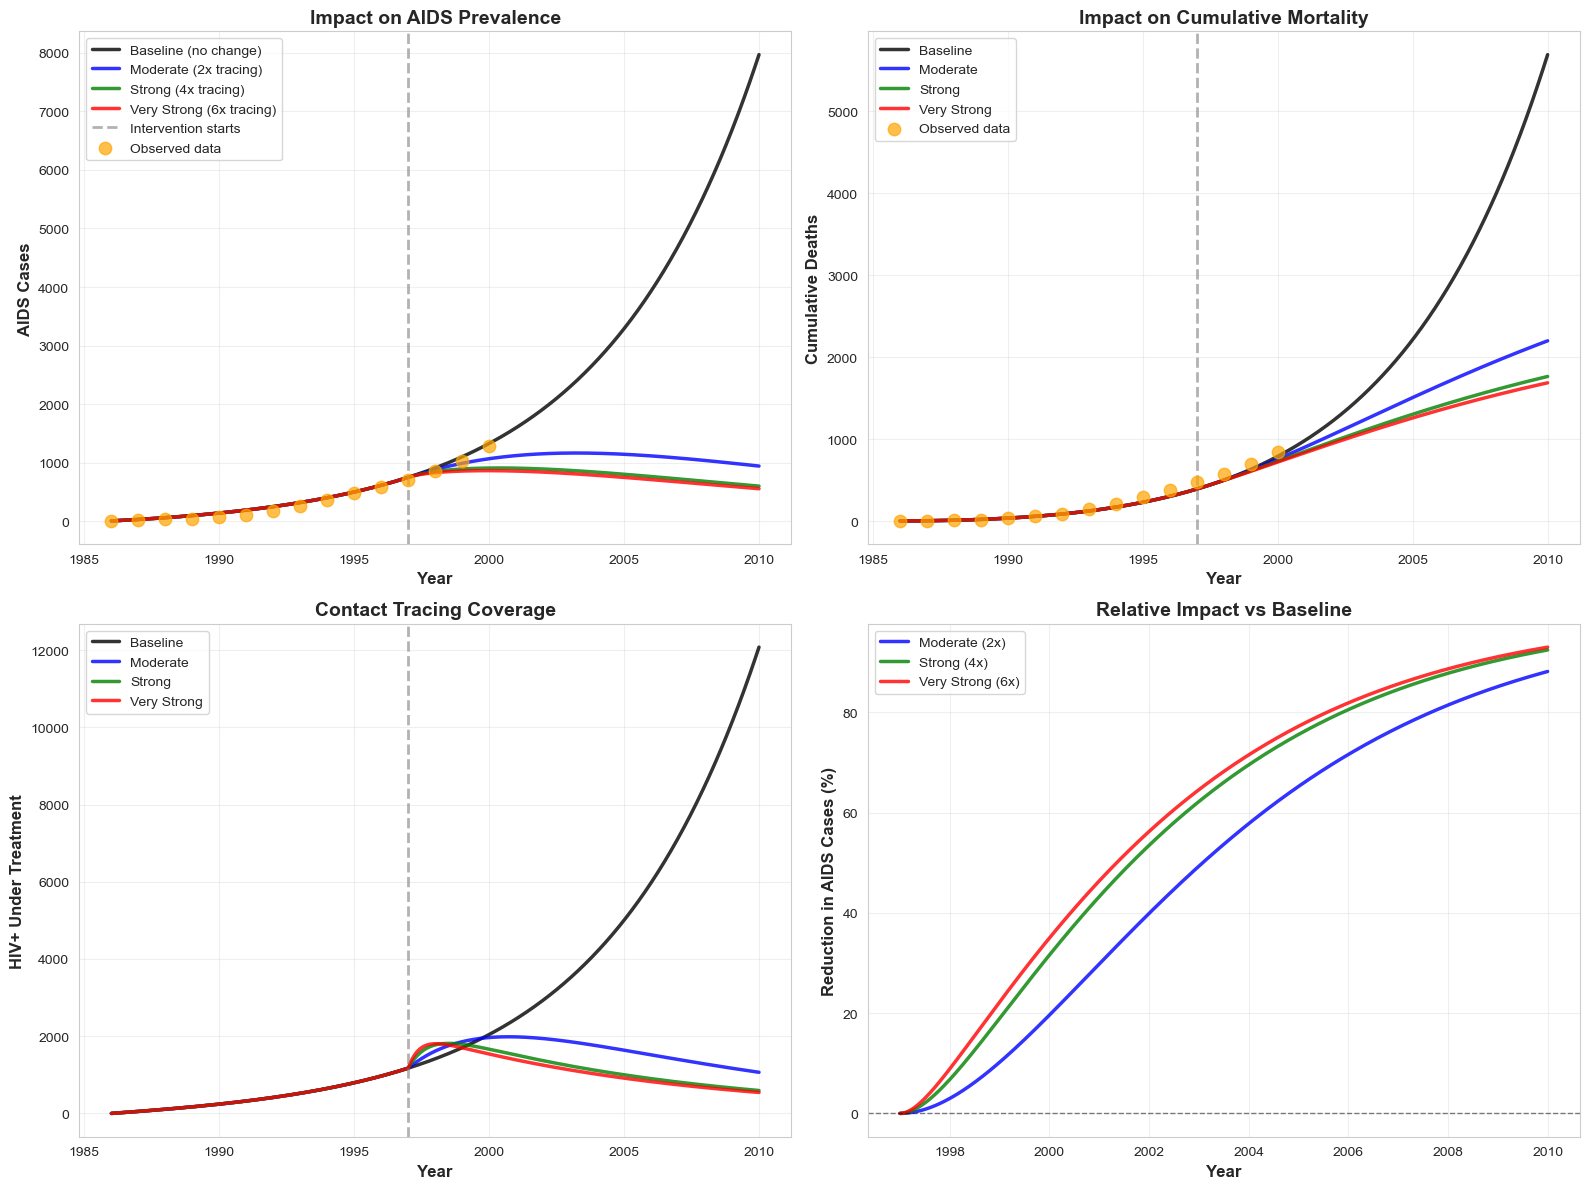

In [8]:
# Extract AIDS and Death compartments for each scenario
A_baseline = scenarios['baseline'][:, 3]
A_moderate = scenarios['2x'][:, 3]
A_strong = scenarios['4x'][:, 3]
A_vstrong = scenarios['6x'][:, 3]

D_baseline = scenarios['baseline'][:, 4]
D_moderate = scenarios['2x'][:, 4]
D_strong = scenarios['4x'][:, 4]
D_vstrong = scenarios['6x'][:, 4]

T_baseline = scenarios['baseline'][:, 2]
T_moderate = scenarios['2x'][:, 2]
T_strong = scenarios['4x'][:, 2]
T_vstrong = scenarios['6x'][:, 2]

# Visualization: Control scenarios
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: AIDS cases comparison
axes[0, 0].plot(years_future, A_baseline, 'k-', linewidth=2.5, 
                label='Baseline (no change)', alpha=0.8)
axes[0, 0].plot(years_future, A_moderate, 'b-', linewidth=2.5, 
                label='Moderate (2x tracing)', alpha=0.8)
axes[0, 0].plot(years_future, A_strong, 'g-', linewidth=2.5, 
                label='Strong (4x tracing)', alpha=0.8)
axes[0, 0].plot(years_future, A_vstrong, 'r-', linewidth=2.5, 
                label='Very Strong (6x tracing)', alpha=0.8)
axes[0, 0].axvline(x=control_start_year, color='gray', linestyle='--', 
                   linewidth=2, label='Intervention starts', alpha=0.6)
axes[0, 0].scatter(df['Year'], df['Cumulative_AIDS'], color='orange', 
                   s=80, label='Observed data', zorder=5, alpha=0.7)
axes[0, 0].set_xlabel('Year', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('AIDS Cases', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Impact on AIDS Prevalence', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=10, loc='upper left')
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Cumulative deaths
axes[0, 1].plot(years_future, D_baseline, 'k-', linewidth=2.5, 
                label='Baseline', alpha=0.8)
axes[0, 1].plot(years_future, D_moderate, 'b-', linewidth=2.5, 
                label='Moderate', alpha=0.8)
axes[0, 1].plot(years_future, D_strong, 'g-', linewidth=2.5, 
                label='Strong', alpha=0.8)
axes[0, 1].plot(years_future, D_vstrong, 'r-', linewidth=2.5, 
                label='Very Strong', alpha=0.8)
axes[0, 1].axvline(x=control_start_year, color='gray', linestyle='--', 
                   linewidth=2, alpha=0.6)
axes[0, 1].scatter(df['Year'], df['Cumulative_Deaths'], color='orange', 
                   s=80, zorder=5, alpha=0.7, label='Observed data')
axes[0, 1].set_xlabel('Year', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Cumulative Deaths', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Impact on Cumulative Mortality', fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=10, loc='upper left')
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: HIV under treatment
axes[1, 0].plot(years_future, T_baseline, 'k-', linewidth=2.5, 
                label='Baseline', alpha=0.8)
axes[1, 0].plot(years_future, T_moderate, 'b-', linewidth=2.5, 
                label='Moderate', alpha=0.8)
axes[1, 0].plot(years_future, T_strong, 'g-', linewidth=2.5, 
                label='Strong', alpha=0.8)
axes[1, 0].plot(years_future, T_vstrong, 'r-', linewidth=2.5, 
                label='Very Strong', alpha=0.8)
axes[1, 0].axvline(x=control_start_year, color='gray', linestyle='--', 
                   linewidth=2, alpha=0.6)
axes[1, 0].set_xlabel('Year', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('HIV+ Under Treatment', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Contact Tracing Coverage', fontsize=14, fontweight='bold')
axes[1, 0].legend(fontsize=10, loc='upper left')
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Percentage reduction in AIDS
idx_control = np.where(t_future >= control_start_time)[0]
reduction_moderate = (A_baseline - A_moderate) / A_baseline * 100
reduction_strong = (A_baseline - A_strong) / A_baseline * 100
reduction_vstrong = (A_baseline - A_vstrong) / A_baseline * 100

axes[1, 1].plot(years_future[idx_control], reduction_moderate[idx_control], 
                'b-', linewidth=2.5, label='Moderate (2x)', alpha=0.8)
axes[1, 1].plot(years_future[idx_control], reduction_strong[idx_control], 
                'g-', linewidth=2.5, label='Strong (4x)', alpha=0.8)
axes[1, 1].plot(years_future[idx_control], reduction_vstrong[idx_control], 
                'r-', linewidth=2.5, label='Very Strong (6x)', alpha=0.8)
axes[1, 1].axhline(y=0, color='k', linestyle='--', linewidth=1, alpha=0.5)
axes[1, 1].set_xlabel('Year', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Reduction in AIDS Cases (%)', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Relative Impact vs Baseline', fontsize=14, fontweight='bold')
axes[1, 1].legend(fontsize=10, loc='upper left')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Quantitative Impact Assessment

In [9]:
# calculate impacts by 2010
idx_2010 = np.argmin(np.abs(years_future - 2010))

# calculate metrics for each scenario
impact_moderate_aids = calculate_impact_metrics(scenarios['baseline'], scenarios['2x'], 3, idx_2010)
impact_strong_aids = calculate_impact_metrics(scenarios['baseline'], scenarios['4x'], 3, idx_2010)
impact_vstrong_aids = calculate_impact_metrics(scenarios['baseline'], scenarios['6x'], 3, idx_2010)

impact_moderate_deaths = calculate_impact_metrics(scenarios['baseline'], scenarios['2x'], 4, idx_2010)
impact_strong_deaths = calculate_impact_metrics(scenarios['baseline'], scenarios['4x'], 4, idx_2010)
impact_vstrong_deaths = calculate_impact_metrics(scenarios['baseline'], scenarios['6x'], 4, idx_2010)

print("PROJECTED IMPACT OF INTERVENTIONS (1997-2010)")
print("\nMODERATE INTERVENTION (2x contact tracing):")
print(f"  AIDS cases averted:     {impact_moderate_aids['absolute_reduction']:.0f}")
print(f"  Deaths averted:         {impact_moderate_deaths['absolute_reduction']:.0f}")
print(f"  AIDS reduction:         {impact_moderate_aids['percent_reduction']:.1f}%")

print("\nSTRONG INTERVENTION (4x contact tracing):")
print(f"  AIDS cases averted:     {impact_strong_aids['absolute_reduction']:.0f}")
print(f"  Deaths averted:         {impact_strong_deaths['absolute_reduction']:.0f}")
print(f"  AIDS reduction:         {impact_strong_aids['percent_reduction']:.1f}%")

print("\nVERY STRONG INTERVENTION (6x contact tracing):")
print(f"  AIDS cases averted:     {impact_vstrong_aids['absolute_reduction']:.0f}")
print(f"  Deaths averted:         {impact_vstrong_deaths['absolute_reduction']:.0f}")
print(f"  AIDS reduction:         {impact_vstrong_aids['percent_reduction']:.1f}%")


PROJECTED IMPACT OF INTERVENTIONS (1997-2010)

MODERATE INTERVENTION (2x contact tracing):
  AIDS cases averted:     7027
  Deaths averted:         3493
  AIDS reduction:         88.2%

STRONG INTERVENTION (4x contact tracing):
  AIDS cases averted:     7370
  Deaths averted:         3928
  AIDS reduction:         92.5%

VERY STRONG INTERVENTION (6x contact tracing):
  AIDS cases averted:     7414
  Deaths averted:         4006
  AIDS reduction:         93.0%


In [10]:
print(impact_moderate_aids)

{'absolute_reduction': 7210.4525762009525, 'percent_reduction': 89.30007329246665, 'baseline_value': 8074.408351923745, 'intervention_val': 863.9557757227926}


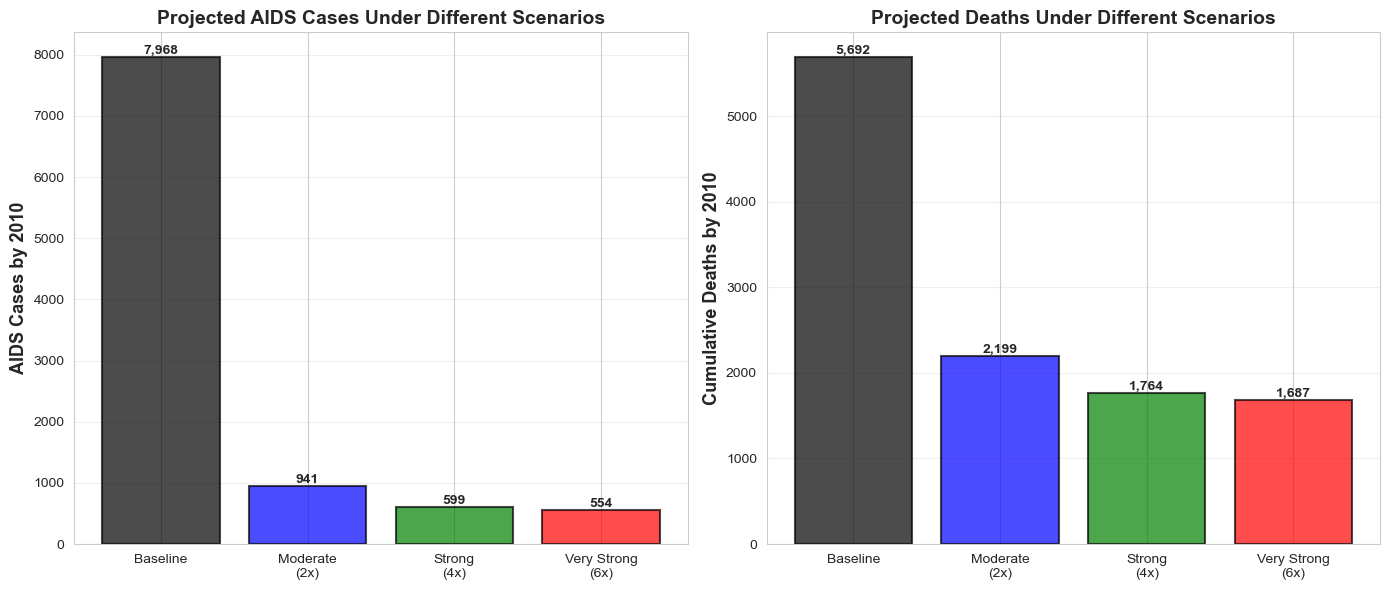

In [10]:
# Summary visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

scenarios_labels = ['Baseline', 'Moderate\n(2x)', 'Strong\n(4x)', 'Very Strong\n(6x)']
aids_values = [
    impact_moderate_aids['baseline_value'],
    impact_moderate_aids['intervention_val'],
    impact_strong_aids['intervention_val'],
    impact_vstrong_aids['intervention_val']
]
deaths_values = [
    impact_moderate_deaths['baseline_value'],
    impact_moderate_deaths['intervention_val'],
    impact_strong_deaths['intervention_val'],
    impact_vstrong_deaths['intervention_val']
]

colors = ['black', 'blue', 'green', 'red']

bars1 = ax1.bar(scenarios_labels, aids_values, color=colors, 
                alpha=0.7, edgecolor='black', linewidth=1.5)
ax1.set_ylabel('AIDS Cases by 2010', fontsize=13, fontweight='bold')
ax1.set_title('Projected AIDS Cases Under Different Scenarios', 
              fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')

# Add values on bars
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height):,}',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

bars2 = ax2.bar(scenarios_labels, deaths_values, color=colors, 
                alpha=0.7, edgecolor='black', linewidth=1.5)
ax2.set_ylabel('Cumulative Deaths by 2010', fontsize=13, fontweight='bold')
ax2.set_title('Projected Deaths Under Different Scenarios', 
              fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

# Add values on bars
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height):,}',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()